# Face Mask Segmentation
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Change current working directory to project folder (1 mark)

In [0]:
import os

os.chdir('/content/drive/My Drive')

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load('images.npy', allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
Hint - print data[10][1] 

In [0]:
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
        img = img[:,:,:3]
    except:
        continue
    X_train[index]=preprocess_input(np.array(img, dtype=np.float32))
    
    for i in data[index][1]:
        x1 = int(i['points'][0]['x']*IMAGE_WIDTH)
        x2 = int(i['points'][1]['x']*IMAGE_WIDTH)
        y1 = int(i['points'][0]['y']*IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y']*IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2]=1

### Print the shape of X_train and mask array  (2 marks)

In [0]:
print(X_train.shape)

(409, 224, 224, 3)


In [0]:
print(masks.shape)

### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

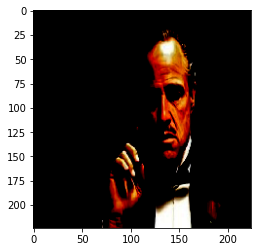

In [0]:
import matplotlib.pyplot as plt
n = 10
print(X_train[n])
plt.imshow(X_train[n])

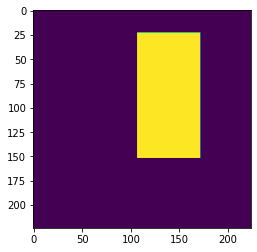

In [0]:
plt.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  

In [0]:
# Model Parameters

ALPHA = 1

EPOCHS = 30
BATCH_SIZE=1
PATIENCE=10

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

def create_model(trainable=True):
    
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights='imagenet')
    
    for layer in model.layers:
        layer.trainable = trainable
        
    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output
    
    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = UpSampling2D()(x)
    
    x = Conv2D(1, kernel_size=1, activation='sigmoid')(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    
    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [0]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(False)

# Print summary
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (10 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coefficient(y_true, y_pred):
    
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (3 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr = 0.001)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (3 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [0]:
model.fit(X_train, masks,
          epochs=EPOCHS,
          batch_size = BATCH_SIZE,
          callbacks = [checkpoint, stop, reduce_lr],
          verbose=1)

Epoch 1/30
408/409 [============================>.] - ETA: 0s - loss: 1.1532 - dice_coefficient: 0.4953
Epoch 00001: loss improved from inf to 1.15252, saving model to model-1.15.h5
409/409 [==============================] - 8s 19ms/step - loss: 1.1525 - dice_coefficient: 0.4954 - lr: 0.0010
Epoch 2/30
407/409 [============================>.] - ETA: 0s - loss: 0.8763 - dice_coefficient: 0.5811
Epoch 00002: loss improved from 1.15252 to 0.87555, saving model to model-0.88.h5
409/409 [==============================] - 7s 18ms/step - loss: 0.8755 - dice_coefficient: 0.5814 - lr: 0.0010
Epoch 3/30
407/409 [============================>.] - ETA: 0s - loss: 0.8324 - dice_coefficient: 0.5978
Epoch 00003: loss improved from 0.87555 to 0.83059, saving model to model-0.83.h5
409/409 [==============================] - 7s 17ms/step - loss: 0.8306 - dice_coefficient: 0.5986 - lr: 0.0010
Epoch 4/30
407/409 [============================>.] - ETA: 0s - loss: 0.7990 - dice_coefficient: 0.6090
Epoch 000

### Get the predicted mask for a sample image   (5 marks)

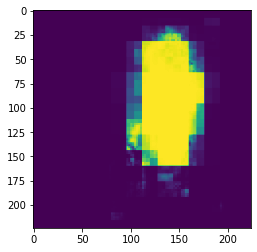

In [0]:
n = 10
sample_image = X_train[n]

WEIGHTS_FILE = 'model-0.68.h5'
model = create_model()
model.load_weights(WEIGHTS_FILE)

pred_mask = model.predict(X_train[n].reshape(1,224,224,3))
pred_mask = pred_mask.reshape(224,224)
plt.imshow(pred_mask)

### Impose the mask on the image (5 marks)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


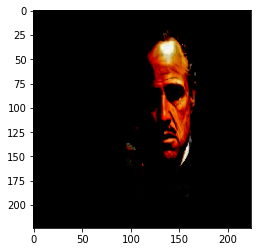

In [0]:
image2 = sample_image

image2[:,:,0] = pred_mask * sample_image[:,:,0]
image2[:,:,1] = pred_mask * sample_image[:,:,1]
image2[:,:,2] = pred_mask * sample_image[:,:,2]

plt.imshow(image2)